<a href="https://colab.research.google.com/github/geon8074/Pytorch_Capstone_Design/blob/main/pytorch_ResNet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [3]:
# ResNet18을 위해 최대한 간단히 수정한 BasicBlock 클래스 정의
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        # 3x3 필터를 사용 (너비와 높이를 줄일 때는 stride 값 조절)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        # 3x3 필터를 사용 (패딩을 1만큼 주기 때문에 너비와 높이가 동일)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        self.shortcut = nn.Sequential() # identity인 경우
        if stride != 1: # stride가 1이 아니라면, Identity mapping이 아닌 경우
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # (핵심) skip connection
        out = F.relu(out)
        return out


# ResNet 클래스 정의
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=4):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # 64개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        print(out.shape)
        out = self.layer1(out)
        print(out.shape)
        out = self.layer2(out)
        print(out.shape)
        out = self.layer3(out)
        print(out.shape)
        out = self.layer4(out)
        print(out.shape)
        out = self.gap(out)
        print(out.shape)
        out = out.view(out.size(0), -1)
        print(out.shape)
        out = self.linear(out)
        print(out.shape)
        return out


# ResNet18 함수 정의
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [5]:
net = ResNet18()

In [4]:
inputs = torch.Tensor(30, 1, 224, 224)
print('텐서의 크기 : {}'.format(inputs.shape))

텐서의 크기 : torch.Size([30, 1, 224, 224])


In [6]:
net(inputs)

torch.Size([30, 64, 224, 224])
torch.Size([30, 64, 224, 224])
torch.Size([30, 128, 112, 112])
torch.Size([30, 256, 56, 56])
torch.Size([30, 512, 28, 28])
torch.Size([30, 512, 1, 1])
torch.Size([30, 512])
torch.Size([30, 4])


tensor([[ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomResizedCrop(224),                         
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomResizedCrop(224), 
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomResizedCrop(224),                        
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
}

In [ ]:
data_dir = '/content/drive/Shareddrives/8:1:1/OCT2017(8:1:1)'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                    for x in ['train', 'val', 'test']}


In [ ]:
train_dataloader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=30,
                                             shuffle=True, drop_last=True, num_workers=2)
                    for x in ['train']}

val_dataloader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=14,
                                             shuffle=True, drop_last=True, num_workers=2)
                    for x in ['val']}                   

test_dataloader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=14,
                                             shuffle=True, drop_last=True, num_workers=2)
                    for x in ['test']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


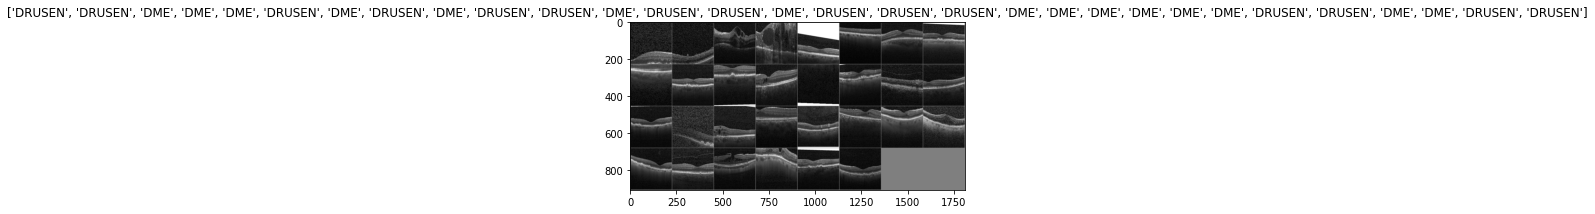

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5])
    std = np.array([0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(train_dataloader['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
for id, data in enumerate(train_dataloader['train']):
  print(id)
  img = data[0]
  label = data[1]
  print(img.shape)
  print(label.shape)
  break

0
torch.Size([30, 1, 224, 224])
torch.Size([30])


In [ ]:
inputs = torch.Tensor(30, 1, 224, 224)
print('텐서의 크기 : {}'.format(inputs.shape))

텐서의 크기 : torch.Size([30, 1, 224, 224])


In [ ]:
device = 'cuda'

net = ResNet18()
net = net.to(device)
net = torch.nn.DataParallel(net)
cudnn.benchmark = True

learning_rate = 0.001
file_name = 'resnet18_retina.pt'

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)


def train(epoch):
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_dataloader['train']):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        benign_outputs = net(inputs)
        loss = criterion(benign_outputs, targets)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = benign_outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if batch_idx % 100 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current benign train accuracy:', str(predicted.eq(targets).sum().item() / targets.size(0)))
            print('Current benign train loss:', loss.item())

    print('\nTotal benign train accuarcy:', 100. * correct / total)
    print('Total benign train loss:', train_loss)


def test(epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(test_dataloader['test']):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

    print('\nTest accuarcy:', 100. * correct / total)
    print('Test average loss:', loss / total)

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')


def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 5:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
net

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

In [ ]:
for epoch in range(0, 10):
    adjust_learning_rate(optimizer, epoch)
    train(epoch)
    test(epoch)


[ Train epoch: 0 ]

Current batch: 0
Current benign train accuracy: 0.13333333333333333
Current benign train loss: 1.4758212566375732

Current batch: 100
Current benign train accuracy: 0.5666666666666667
Current benign train loss: 1.2886719703674316

Current batch: 200
Current benign train accuracy: 0.6333333333333333
Current benign train loss: 0.9159958362579346

Current batch: 300
Current benign train accuracy: 0.6333333333333333
Current benign train loss: 0.9634922742843628

Current batch: 400
Current benign train accuracy: 0.6
Current benign train loss: 1.1253116130828857

Current batch: 500
Current benign train accuracy: 0.6
Current benign train loss: 1.0161867141723633

Current batch: 600
Current benign train accuracy: 0.7
Current benign train loss: 0.6955928802490234

Current batch: 700
Current benign train accuracy: 0.7333333333333333
Current benign train loss: 0.6845703125

Current batch: 800
Current benign train accuracy: 0.8333333333333334
Current benign train loss: 0.57186

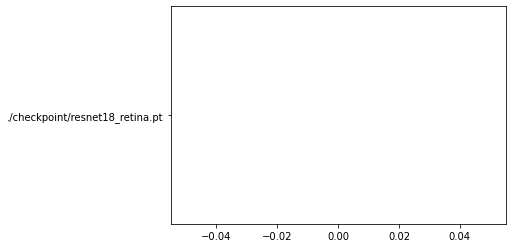

In [ ]:
plt.plot('./checkpoint/' + file_name)

In [ ]:
plt.plot(뭘 넣을까)
plt.title('train loss')
plt.xlabel('step')
plt.ylabel('loss')
plt.show()